In [1]:
from epyt import epanet
import matplotlib.pyplot as plt
import numpy as np

Full documentation of [epyt](https://epanet-python-toolkit-epyt.readthedocs.io/en/latest/api.html).

## Basic Operations

For the demonstration purposes the Hanoi network will be used.

In [2]:
input_file = "../data/Hanoi.inp"
G = epanet(input_file)

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Hanoi.inp loaded successfully.



The library allows to query some basic information about the WDN.

In [3]:
G.NodeCount, G.LinkCount, G.getNodeBaseDemands()

(32,
 34,
 {1: array([247.22000122, 236.11000061,  36.11000061, 201.38999939,
         279.17001343, 375.        , 152.77999878, 145.83000183,
         145.83000183, 138.88999939, 155.55999756, 261.10998535,
         170.83000183,  77.77999878,  86.11000061, 240.27999878,
         373.60998535,  16.67000008, 354.17001343, 258.32998657,
         134.72000122, 290.27999878, 227.77999878,  47.22000122,
         250.        , 102.77999878,  80.55999756, 100.        ,
         100.        ,  29.17000008, 223.61000061,   0.        ])})

Epyt indexes nodes starting from 1, so if the info about the node (pressure or demand) is retrieved from numpy array, then it needs to be accessed with node_id - 1.

In [4]:
min(G.NodeIndex), max(G.NodeIndex)

(1, 32)

We can also plot the net, however the WDN cannnot be too big.

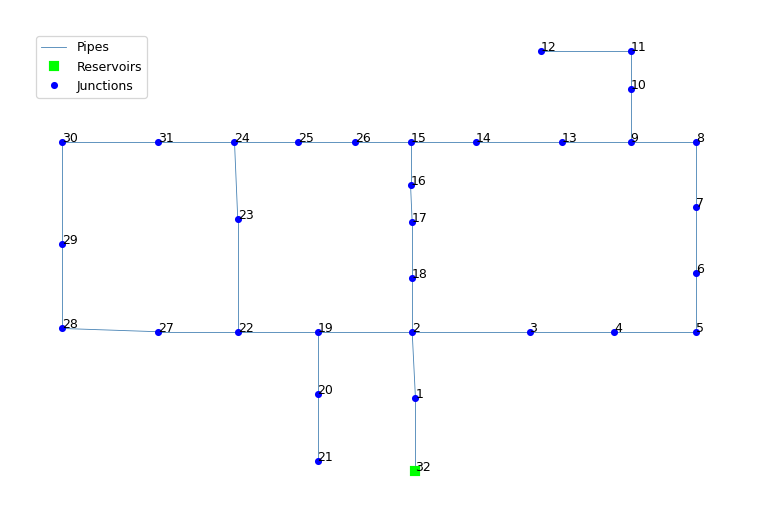

In [5]:
G.plot(nodesindex=list(range(1, 33)), fontsize=3);

Adjacency matrix can be used to compute pairwise distances (Floyd-Warshall algorithm) between nodes. This precomputation is needed in the cost function for the leakage detection algorithm.

In [6]:
adj_matrix = G.getAdjacencyMatrix()
adj_matrix.shape

(32, 32)

In [7]:
import numba

@numba.jit(nopython=True)
def triple_loop(dist: np.ndarray, n: int) -> np.ndarray:
    for k in range(n):
        for i in range(n):
            for j in range(n):
                dist[i][j] = min(dist[i][j], dist[i][k] + dist[k][j])
    return dist

def floyd_warshall(adj_matrix: np.ndarray, undirected: bool = True) -> np.ndarray:
    n = adj_matrix.shape[0]
    if undirected:
        adj_matrix = np.maximum(adj_matrix, adj_matrix.T)
        
    dist = np.full_like(adj_matrix, float(n + 1))
    dist[adj_matrix > 0] = 1.0
    np.fill_diagonal(dist, 0.0)

    dist = triple_loop(dist, n)
    
    return dist

In [8]:
dist = floyd_warshall(adj_matrix)
dist

array([[0., 1., 2., ..., 7., 6., 1.],
       [1., 0., 1., ..., 6., 5., 2.],
       [2., 1., 0., ..., 7., 6., 3.],
       ...,
       [7., 6., 7., ..., 0., 1., 8.],
       [6., 5., 6., ..., 1., 0., 7.],
       [1., 2., 3., ..., 8., 7., 0.]])

The WDNs are directed graphs (water usually flows in one direction). For computing distances however it makes more sense to treat it as undirected graph, otherwise some distances will be infinite.

## Running Simulations

Changing DDA to PDA

In [9]:
help(G.setDemandModel)

Help on method setDemandModel in module epyt.epanet:

setDemandModel(code, pmin, preq, pexp) method of epyt.epanet.epanet instance
    Sets the type of demand model to use and its parameters.

    :param code: Type of demand model
        * 'DDA' = Demand driven analysis (in which case the
        remaining three parameter values are ignored)
        * 'PDA' = Pressure driven analysis
    :type code: str
    :param pmin: Pressure below which there is no demand
    :type pmin: float
    :param preq: Pressure required to deliver full demand
    :type preq: float
    :param pexp: Pressure exponent in demand function
    :type pexp: float
    :return: None

    Example:

    >>> d.getDemandModel().disp()                  # Print the demand model
    >>> type = 'PDA'
    >>> pmin = 0
    >>> preq = 0.1
    >>> pexp = 0.5
    >>> d.setDemandModel(type, pmin, preq, pexp)   # Sets the demand model
    >>> d.getDemandModel().to_dict()

    See also getDemandModel, setNodeBaseDemands, setNodeJun

In [10]:
G.setDemandModel(code="PDA", pmin=0.0, preq=0.1, pexp=0.5)

Runs a simulation, the details (duration, report step) can be set in the config file or through the api.

In [11]:
help(G.getComputedHydraulicTimeSeries)

Help on method getComputedHydraulicTimeSeries in module epyt.epanet:

getComputedHydraulicTimeSeries(matrix=True, *argv) method of epyt.epanet.epanet instance
    Computes hydraulic simulation and retrieves all time-series.

    Data that is computed:
      1) Time              8)  Velocity
      2) Pressure          9)  HeadLoss
      3) Demand            10) Status
      4) DemandDeficit     11) Setting
      5) Head              12) Energy
      6) TankVolume        13) Efficiency
      7) Flow

    Example 1:

    # Retrieves all the time-series data
    >>> d.getComputedHydraulicTimeSeries()

    Example 2:

    # Retrieves all the time-series demands
    >>> d.getComputedHydraulicTimeSeries().Demand
    # Retrieves all the time-series flows
    >>> d.getComputedHydraulicTimeSeries().Flow

    Example 3:

    # Retrieves all the time-series Time, Pressure, Velocity
    >>> data = d.getComputedHydraulicTimeSeries(['Time',
    ...                                         'Pressure',


In [12]:
G.setTimeReportingStep(600) # 600 seconds - 10 mins
G.setTimeSimulationDuration(3600 * 48) # 48 hours
G.setTimePatternStep(600) # Same as reporting step

In [13]:
measures = G.getComputedHydraulicTimeSeries()
measures.Pressure.shape

(289, 32)

Actually it does not always work as expected (it's better to set those particular values in the config file)

## Leak scenario

Simulating leaks can obtained by changing demand pattern

In [14]:
leak_start = 144 # We assume that leaks starts halfway through the simulation

leak_node_id = '10' # Node ids not always have to be numeric and its something different that nodes index
leak_node_index = G.getNodeIndex(leak_node_id)

leak_node_id, leak_node_index

('10', 9)

In [15]:
leak_pattern = np.ones(289)
leak_pattern[leak_start:] = 3 # Multiply by 3

pattern_index = G.addPattern('leak', leak_pattern) # Add demand pattern
G.setNodeDemandPatternIndex(leak_node_index, pattern_index)
G.setNodeBaseDemands(leak_node_index, 50)

In [16]:
measures = G.getComputedHydraulicTimeSeries()
leak_node_demand = measures.Demand[:, leak_node_index - 1]
np.unique_counts(leak_node_demand)

UniqueCountsResult(values=array([ 50.00001144, 150.00001526]), counts=array([144, 145]))

at the end we can save epanet object as a new .inp file

In [19]:
G.saveInputFile("modified_Hanoi.inp")

## Trying out some bigger network

In [20]:
G = epanet("../data/z_cisnieniem_v1.inp")

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File z_cisnieniem_v1.inp loaded successfully.



In [21]:
G.NodeCount, G.LinkCount

(8528, 8753)

In [ ]:
# G.plot() -- better not to

In [22]:
adj_mat = G.getAdjacencyMatrix()

In [23]:
dist = floyd_warshall(adj_mat)

Approximately four minutes. Without numba this would take around 3 days

In [24]:
G.setTimeReportingStep(3600) # every hour
G.setTimeSimulationDuration(3600 * 168) # 168 hours

In [25]:
m = G.getComputedHydraulicTimeSeries()

Running one simulation through python API took 8 seconds